In [1]:
from pathlib import Path
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import re
import tensorflow as tf
import transformers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
DATA_ROOT = Path("..")/"input"/ "jigsaw-multilingual-toxic-comment-classification/"


In [4]:
df1,df2,df3 = [pd.read_csv(DATA_ROOT / fname, usecols=["comment_text", "toxic"]) for fname in ["jigsaw-toxic-comment-train.csv",
                                                            "jigsaw-unintended-bias-train.csv",
                                                            "validation.csv"
                                                                       ]]



test, sample= [pd.read_csv(DATA_ROOT / fname) for fname in ["test.csv",
                                                            "sample_submission.csv"
                                                            ]]


In [5]:
# #Clean up the comment text
# def clean_text(text):
#     text = text.lower()
    
#     text = re.sub(r"what's", "what is ", text)
#     text = re.sub(r"\'s", " ", text)
#     text = re.sub(r"\'ve", " have ", text)
#     text = re.sub(r"can't", "cannot ", text)
#     text = re.sub(r"n't", " not ", text)
#     text = re.sub(r"i'm", "i am ", text)
#     text = re.sub(r"\'re", " are ", text)
#     text = re.sub(r"\'d", " would ", text)
#     text = re.sub(r"\'ll", " will ", text)
#     text = re.sub(r"\'scuse", " excuse ", text)
#     text = re.sub('\W', ' ', text)
#     text = re.sub('\s+', ' ', text)
#     text = text.strip(' ')
#     return text

In [6]:
# #Clean up the comment text
# def clean_text(g_text):
    
#     # Special characters
#     g_text = re.sub(r"\x89Û_", "", g_text)
#     g_text = re.sub(r"\x89ÛÒ", "", g_text)
#     g_text = re.sub(r"\x89ÛÓ", "", g_text)
#     g_text = re.sub(r"\x89ÛÏWhen", "When", g_text)
#     g_text = re.sub(r"\x89ÛÏ", "", g_text)
#     g_text = re.sub(r"China\x89Ûªs", "China's", g_text)
#     g_text = re.sub(r"let\x89Ûªs", "let's", g_text)
#     g_text = re.sub(r"\x89Û÷", "", g_text)
#     g_text = re.sub(r"\x89Ûª", "", g_text)
#     g_text = re.sub(r"\x89Û\x9d", "", g_text)
#     g_text = re.sub(r"å_", "", g_text)
#     g_text = re.sub(r"\x89Û¢", "", g_text)
#     g_text = re.sub(r"\x89Û¢åÊ", "", g_text)
#     g_text = re.sub(r"fromåÊwounds", "from wounds", g_text)
#     g_text = re.sub(r"åÊ", "", g_text)
#     g_text = re.sub(r"åÈ", "", g_text)
#     g_text = re.sub(r"JapÌ_n", "Japan", g_text)    
#     g_text = re.sub(r"Ì©", "e", g_text)
#     g_text = re.sub(r"å¨", "", g_text)
#     g_text = re.sub(r"SuruÌ¤", "Suruc", g_text)
#     g_text = re.sub(r"åÇ", "", g_text)
#     g_text = re.sub(r"å£3million", "3 million", g_text)
#     g_text = re.sub(r"åÀ", "", g_text)
    
#     # Contractions
#     g_text = re.sub(r"he's", "he is", g_text)
#     g_text = re.sub(r"there's", "there is", g_text)
#     g_text = re.sub(r"We're", "We are", g_text)
#     g_text = re.sub(r"That's", "That is", g_text)
#     g_text = re.sub(r"won't", "will not", g_text)
#     g_text = re.sub(r"they're", "they are", g_text)
#     g_text = re.sub(r"Can't", "Cannot", g_text)
#     g_text = re.sub(r"wasn't", "was not", g_text)
#     g_text = re.sub(r"don\x89Ûªt", "do not", g_text)
#     g_text = re.sub(r"aren't", "are not", g_text)
#     g_text = re.sub(r"isn't", "is not", g_text)
#     g_text = re.sub(r"What's", "What is", g_text)
#     g_text = re.sub(r"haven't", "have not", g_text)
#     g_text = re.sub(r"hasn't", "has not", g_text)
#     g_text = re.sub(r"There's", "There is", g_text)
#     g_text = re.sub(r"He's", "He is", g_text)
#     g_text = re.sub(r"It's", "It is", g_text)
#     g_text = re.sub(r"You're", "You are", g_text)
#     g_text = re.sub(r"I'M", "I am", g_text)
#     g_text = re.sub(r"shouldn't", "should not", g_text)
#     g_text = re.sub(r"wouldn't", "would not", g_text)
#     g_text = re.sub(r"i'm", "I am", g_text)
#     g_text = re.sub(r"I\x89Ûªm", "I am", g_text)
#     g_text = re.sub(r"I'm", "I am", g_text)
#     g_text = re.sub(r"Isn't", "is not", g_text)
#     g_text = re.sub(r"Here's", "Here is", g_text)
#     g_text = re.sub(r"you've", "you have", g_text)
#     g_text = re.sub(r"you\x89Ûªve", "you have", g_text)
#     g_text = re.sub(r"we're", "we are", g_text)
#     g_text = re.sub(r"what's", "what is", g_text)
#     g_text = re.sub(r"couldn't", "could not", g_text)
#     g_text = re.sub(r"we've", "we have", g_text)
#     g_text = re.sub(r"it\x89Ûªs", "it is", g_text)
#     g_text = re.sub(r"doesn\x89Ûªt", "does not", g_text)
#     g_text = re.sub(r"It\x89Ûªs", "It is", g_text)
#     g_text = re.sub(r"Here\x89Ûªs", "Here is", g_text)
#     g_text = re.sub(r"who's", "who is", g_text)
#     g_text = re.sub(r"I\x89Ûªve", "I have", g_text)
#     g_text = re.sub(r"y'all", "you all", g_text)
#     g_text = re.sub(r"can\x89Ûªt", "cannot", g_text)
#     g_text = re.sub(r"would've", "would have", g_text)
#     g_text = re.sub(r"it'll", "it will", g_text)
#     g_text = re.sub(r"we'll", "we will", g_text)
#     g_text = re.sub(r"wouldn\x89Ûªt", "would not", g_text)
#     g_text = re.sub(r"We've", "We have", g_text)
#     g_text = re.sub(r"he'll", "he will", g_text)
#     g_text = re.sub(r"Y'all", "You all", g_text)
#     g_text = re.sub(r"Weren't", "Were not", g_text)
#     g_text = re.sub(r"Didn't", "Did not", g_text)
#     g_text = re.sub(r"they'll", "they will", g_text)
#     g_text = re.sub(r"they'd", "they would", g_text)
#     g_text = re.sub(r"DON'T", "DO NOT", g_text)
#     g_text = re.sub(r"That\x89Ûªs", "That is", g_text)
#     g_text = re.sub(r"they've", "they have", g_text)
#     g_text = re.sub(r"i'd", "I would", g_text)
#     g_text = re.sub(r"should've", "should have", g_text)
#     g_text = re.sub(r"You\x89Ûªre", "You are", g_text)
#     g_text = re.sub(r"where's", "where is", g_text)
#     g_text = re.sub(r"Don\x89Ûªt", "Do not", g_text)
#     g_text = re.sub(r"we'd", "we would", g_text)
#     g_text = re.sub(r"i'll", "I will", g_text)
#     g_text = re.sub(r"weren't", "were not", g_text)
#     g_text = re.sub(r"They're", "They are", g_text)
#     g_text = re.sub(r"Can\x89Ûªt", "Cannot", g_text)
#     g_text = re.sub(r"you\x89Ûªll", "you will", g_text)
#     g_text = re.sub(r"I\x89Ûªd", "I would", g_text)
#     g_text = re.sub(r"let's", "let us", g_text)
#     g_text = re.sub(r"it's", "it is", g_text)
#     g_text = re.sub(r"can't", "cannot", g_text)
#     g_text = re.sub(r"don't", "do not", g_text)
#     g_text = re.sub(r"you're", "you are", g_text)
#     g_text = re.sub(r"i've", "I have", g_text)
#     g_text = re.sub(r"that's", "that is", g_text)
#     g_text = re.sub(r"i'll", "I will", g_text)
#     g_text = re.sub(r"doesn't", "does not", g_text)
#     g_text = re.sub(r"i'd", "I would", g_text)
#     g_text = re.sub(r"didn't", "did not", g_text)
#     g_text = re.sub(r"ain't", "am not", g_text)
#     g_text = re.sub(r"you'll", "you will", g_text)
#     g_text = re.sub(r"I've", "I have", g_text)
#     g_text = re.sub(r"Don't", "do not", g_text)
#     g_text = re.sub(r"I'll", "I will", g_text)
#     g_text = re.sub(r"I'd", "I would", g_text)
#     g_text = re.sub(r"Let's", "Let us", g_text)
#     g_text = re.sub(r"you'd", "You would", g_text)
#     g_text = re.sub(r"It's", "It is", g_text)
#     g_text = re.sub(r"Ain't", "am not", g_text)
#     g_text = re.sub(r"Haven't", "Have not", g_text)
#     g_text = re.sub(r"Could've", "Could have", g_text)
#     g_text = re.sub(r"youve", "you have", g_text)  
#     g_text = re.sub(r"donå«t", "do not", g_text)   
            
#     # Character entity references
#     g_text = re.sub(r"&gt;", ">", g_text)
#     g_text = re.sub(r"&lt;", "<", g_text)
#     g_text = re.sub(r"&amp;", "&", g_text)
    
           
#     # Urls
#     g_text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", g_text)
        
#     # Words with punctuations and special characters
#     punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
#     for p in punctuations:
#         g_text = g_text.replace(p, f' {p} ')
        
#     # ... and ..
#     g_text = g_text.replace('...', ' ... ')
#     if '...' not in g_text:
#         g_text = g_text.replace('..', ' ... ')      
    
    
#     g_text = re.sub(r"\'scuse", " excuse ", g_text)
#     g_text = re.sub('\W', ' ', g_text)
#     g_text = re.sub('\s+', ' ', g_text)
#     g_text = g_text.strip(' ')
#     return g_text

In [7]:
df2['toxic'] = df2['toxic'].apply(lambda x: 0 if x<0.5 else 1)

In [8]:
df2 = pd.concat([
    
    df2[['comment_text', 'toxic']].query('toxic==1'),
    df2[['comment_text', 'toxic']].query('toxic==0').sample(n=500000, random_state=0)
])

In [9]:
# Percentage of unlabelled comments
unlabelled_df2_all = df2[(df2['toxic']!=1) ]
print('Percentage of unlabelled comments in df2 ', len(unlabelled_df2_all)/len(df2)*100)

Percentage of unlabelled comments in df2  76.67406315795931


In [10]:
# # clean the comment_text in df1
# df1['comment_text'] = df1['comment_text'].map(lambda com : clean_text(com))
# # clean the comment_text in df2
# df2['comment_text'] = df2['comment_text'].map(lambda com : clean_text(com))

In [11]:
# Character length for the rows in the df1 & df2 data
df1['char_length'] = df1['comment_text'].apply(lambda x: len(str(x)))
df2['char_length'] = df2['comment_text'].apply(lambda x: len(str(x)))

In [12]:
# Character length for the rows in the training data
df1= df1[df1['char_length'] >= 545] 
df2= df2[df2['char_length'] >= 545] 

In [13]:
train = pd.concat([df1, df2], axis=0).reset_index(drop=True)
train = train.sample(frac=1).reset_index(drop=True).head(200000)
train = train.reset_index(drop=True)
valid = df3
valid = valid.reset_index(drop=True)

In [14]:
# train['toxic'] = train['toxic'].apply(lambda x: 0 if x<0.5 else 1)

In [15]:
train.describe()

,toxic,char_length
count,150734.000000,150734.000000
mean,0.153768,926.787931
std,0.360727,548.294655
min,0.000000,545.000000
25%,0.000000,656.000000
50%,0.000000,821.000000
75%,0.000000,989.000000
max,1.000000,5000.000000


In [16]:
# Percentage of unlabelled comments
unlabelled_in_all = train[(train['toxic']!=1) ]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train)*100)

Percentage of unlabelled comments is  84.62324359467671


In [17]:
# # check for any 'null' comment in training data
# no_comment = train[train['comment_text'].isnull()]
# len(no_comment)

In [18]:
test.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [19]:
# # check for any 'null' comment in test data
# no_comment = test[test['content'].isnull()]
# len(no_comment)

In [20]:
# # check for any 'null' comment in validation data
# no_comment = valid[valid['comment_text'].isnull()]
# len(no_comment)

In [21]:
# total rows in train, test valid data
print('Total rows in training dataset is {}'.format(len(train)))
print('Total rows in validation dataset is {}'.format(len(valid)))
print('Total rows in test dataset is {}'.format(len(test)))

Total rows in training dataset is 150734
Total rows in validation dataset is 8000
Total rows in test dataset is 63812


In [22]:
# # Character length for the rows in the training data
# train['char_length'] = train['comment_text'].apply(lambda x: len(str(x)))

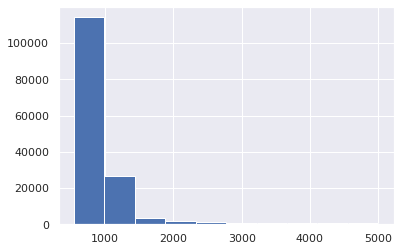

In [23]:
# histogram plot for text length
sns.set()
train['char_length'].hist()
plt.show()

In [24]:
# top 10 largest values in column char_length 
train.nlargest(10, 'char_length') 

,comment_text,toxic,char_length
980,FUCK NIGGER CUNT BITCH WHORE NIGGER SLUT CUNT ...,1,5000
1359,JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST...,1,5000
2839,Anime Rules! Comedy Sucks! Anime Rules! Comedy...,1,5000
3855,"MUAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA, YOU C...",1,5000
7939,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,5000
8157,DIE MOTHERFUCKER DIE! DIE MOTHERFUCKER DIE! DI...,1,5000
10854,I fuck niggas! I fuck niggas! I fuck niggas! I...,1,5000
11085,This page has been marked with Essjay's chode....,0,5000
11880,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,1,5000
12987,delete this pagedelete this pagedelete this pa...,0,5000


In [25]:
# top 10 smallest values in column char_length 
train.nsmallest(10, 'char_length') 

,comment_text,toxic,char_length
599,"Vanilla Ice \n\nWell first of all, it's been 2...",0,545
665,Free trade with China? I can see even more goo...,0,545
1084,Too late. Its already happening. CBC and Trude...,1,545
1377,"""Your argument, then, is that someone's vote s...",0,545
1383,Some of you white folks view the world in pecu...,1,545
1541,"The river is very similar to 200 years sgo, sh...",0,545
1697,"""\n\n Have one of these \n\n The Original Bar...",0,545
1966,"Hi. No, I am sorry but this is utterly bogus. ...",0,545
2021,Agree on airports and in fact outside of North...,0,545
2200,One wonders how a salaried gig that pays about...,0,545


In [26]:
# # Character length for the rows in the training data
# train= train[train['char_length'] >= 15] 

In [27]:
# # top 10 largest values in column char_length 
# train.nsmallest(10, 'char_length') 

In [28]:
# Percentage of unlabelled comments
unlabelled_in_all = valid[(valid['toxic']!=1) ]
print('Percentage of unlabelled comments in validation is ', len(unlabelled_in_all)/len(valid)*100)

Percentage of unlabelled comments in validation is  84.625


In [29]:
valid.describe()

,toxic
count,8000.000000
mean,0.153750
std,0.360731
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [30]:
test['char_length'] = test['content'].apply(lambda x: len(str(x)))

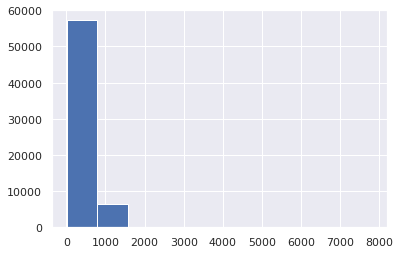

In [31]:
sns.set()
test['char_length'].hist()
plt.show()

In [32]:
# top 10 largest values test dataset  in column char_length 
test.nlargest(10, 'char_length') 

,id,content,lang,char_length
12665,12665,YYY!!!!!!!!TE ENGRASASTE EL ANO PARA QUE TE PU...,es,7794
57572,57572,BÖYLE YAPTIĞIM İÇİN ÖZÜR DİLERİM www.turkforum...,tr,6668
58319,58319,http://pussymania.cn/index71.html http://pussy...,tr,4086
30647,30647,Hai mai visto un vandalo vandalizzare la pagin...,it,3691
13254,13254,seus ranhosos! deviam ter vergonha!!! =@ axam ...,pt,3386
53420,53420,SAN BAUDILIO NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...,es,3190
53053,53053,http://www.the-afc.com/en/event-information/a...,es,2679
36372,36372,Fuck fuck fuck. fuck aurévilly. fuck l estie d...,fr,2469
32759,32759,Vai se fude para de fude os outros e cuida da ...,pt,2348
34862,34862,Capítulo 1SemanaCandidatasExplicaciónResultado...,es,2071


In [33]:
# top 10 smallest values test dataset  in column char_length 
test.nsmallest(10, 'char_length') 

,id,content,lang,char_length
9069,9069,siktir lan amq,tr,15
18092,18092,niker vos mere,fr,20
62671,62671,"Hola, fue quién borró el",es,25
44919,44919,"Hola, he revertido tu edición en",es,33
61846,61846,kunst Discussão kunst Discussão,pt,33
2819,2819,Прошу восстановить статью Готово. !,ru,38
34578,34578,Marcos discussão . Marcos discussão .,pt,38
61898,61898,Arges (discussão) Arges (discussão),pt,38
22906,22906,Leandro Martinez msg Leandro Martinez msg,pt,44
53027,53027,Marcos discussão . Marcos discussão .,pt,45


In [34]:
valid['char_length'] = valid['comment_text'].apply(lambda x: len(str(x)))

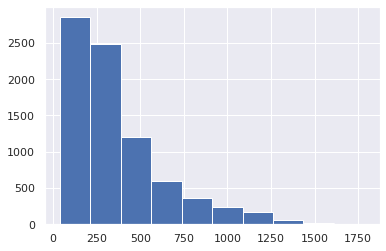

In [35]:
sns.set()
valid['char_length'].hist()
plt.show()

In [36]:
# top 10 largest values valid dataset  in column char_length 
valid.nlargest(10, 'char_length') 

,comment_text,toxic,char_length
6744,50px 75px|right|Gülücük Herkesin katkıda bulu...,0,1785
7535,50px 75px|right|Gülücük Herkesin katkıda bulu...,0,1703
580,50px 75px|right|Gülücük Herkesin katkıda bulu...,0,1690
7873,:Resim:Aksarayegitimspor logo.jpg kaynak ve li...,0,1655
3942,Kamondo aile mensuplarının adlarını ve soyadla...,0,1640
3365,Bakü devlet üniversitesinde öğretim görevlisi ...,0,1619
598,Dmax.gif kaynak ve lisans sorunu 64px|left|...,0,1606
7462,"Hoş Geldin ! Merhaba, tamamen gönüllü ka...",0,1592
6826,Hemen verdiginiz yanit icin tesekkurler; ama h...,0,1569
3399,Aşağı Çat TANAS aşireti hakimiyeti altında var...,0,1565


In [37]:
# top 10 smallest values valid dataset  in column char_length 
valid.nsmallest(10, 'char_length') 

,comment_text,toxic,char_length
6950,V A I A L A V O R A R E T E R R O N E !,1,39
6433,pinches putos culeros no lean esta porqueria de,1,48
5702,"Hola: Feliz 2006. Vaya, vaya, al parecer me pa...",0,55
7922,"Recién me entero que sos de acá, que cosa, jaj...",0,60
4840,El evento inicia el 21 de Mayo y finaliza el 1...,0,62
4146,Ni en pedo. Clarín Miente pero el IndeK da Cát...,0,64
2719,Ehi! Ma io ti picchio P A quest ora si va a na...,0,65
4323,Te he dejado un aviso en la discusion del arti...,0,70
1331,Ya sabes que el grado de tontería no tiene lím...,0,72
4511,"Ahora quedó de lujo, es más cómodo de leer, yo...",0,72


In [38]:
train = train.drop('char_length',axis=1)
valid = valid.drop('char_length',axis=1)
test = test.drop('char_length',axis=1)

In [39]:
# # # Function to encode the text
def encode_fn(texts, tokenizer, maxlen=512):
    encode = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(encode['input_ids'])

In [40]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [41]:
# First load the real tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')


In [42]:
%%time
x_train = encode_fn(train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_valid = encode_fn(valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_test =  encode_fn(test.content.astype(str), tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

CPU times: user 6min 54s, sys: 1.86 s, total: 6min 55s
Wall time: 6min 55s


In [43]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [44]:
# Function to build the MODEL
def model_fn(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    
    cls_token = sequence_output[:, 0, :]

    
    
#     layers1 = Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='elu')(cls_token)
  
#     layers3 = Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='elu')(layers1)
  
#     layers5 = Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='elu')(layers3)
  
#     layers7 = Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='elu')(layers5)
  
    
    
    
#     out = Dense(1, activation='sigmoid')(layers7)

  
    out = Dense(1, activation='sigmoid')(cls_token)
    model = Model(inputs=input_word_ids, outputs=out)
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
    model.compile(optimizer, loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC()] )
    return model
    


In [45]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-large")   
        
    )
    model = model_fn(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 1s, sys: 36.7 s, total: 2min 38s
Wall time: 2min 39s


In [46]:
# n_steps = x_train.shape[0] // BATCH_SIZE
# train_history = model.fit(
#     train_dataset,
#     steps_per_epoch=n_steps,
#     #callbacks=[callback],
#     validation_data=valid_dataset,
#     epochs=EPOCHS
# )

In [47]:
# n_steps = x_valid.shape[0] // BATCH_SIZE
# train_history_2 = model.fit(
#     valid_dataset.repeat(),
#     steps_per_epoch=n_steps,
#     epochs=EPOCHS*2
# )

In [48]:
# sample['toxic'] = model.predict(test_dataset, verbose=1)
# sample.to_csv('submission.csv', index=False)

In [49]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# file_path = "best_model.hdf5"
# check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
#                               save_best_only = True, mode = "min")
# #ra_val = RocAucEvaluation(validation_data=valid_dataset, interval = 1)
# early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)



In [50]:

# n_steps = x_train.shape[0] // BATCH_SIZE

# train_history = model.fit(
#     train_dataset,
#     steps_per_epoch=n_steps,
#     validation_steps=127,
#     #callbacks = [check_point, early_stop],
#     validation_data=valid_dataset,
#     epochs=4
# )

In [51]:
callback_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)



In [52]:
n_steps = x_train.shape[0]// BATCH_SIZE
train_history1 = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [callback_stop],
    validation_data=valid_dataset,
    epochs=20
)

Train for 1177 steps, validate for 63 steps
Epoch 1/20
1177/1177 [==============================] - 783s 665ms/step - loss: 0.2315 - auc: 0.9274 - val_loss: 0.3033 - val_auc: 0.9019
Epoch 2/20
1177/1177 [==============================] - 567s 482ms/step - loss: 0.1984 - auc: 0.9485 - val_loss: 0.3254 - val_auc: 0.8862
Epoch 3/20
1177/1177 [==============================] - 567s 482ms/step - loss: 0.1795 - auc: 0.9584 - val_loss: 0.3726 - val_auc: 0.8751
Epoch 4/20
1177/1177 [==============================] - 570s 484ms/step - loss: 0.1612 - auc: 0.9669 - val_loss: 0.5340 - val_auc: 0.7958
Epoch 5/20
1177/1177 [==============================] - 567s 482ms/step - loss: 0.1373 - auc: 0.9760 - val_loss: 0.5330 - val_auc: 0.8073
Epoch 6/20
1177/1177 [==============================] - 599s 509ms/step - loss: 0.1177 - auc: 0.9823 - val_loss: 0.6018 - val_auc: 0.7956


In [53]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    callbacks = [callback_stop],
    epochs=EPOCHS*2
)

Train for 62 steps
Epoch 1/6
62/62 [==============================] - 127s 2s/step - loss: 0.2442 - auc: 0.9179
Epoch 2/6
62/62 [==============================] - 143s 2s/step - loss: 0.1909 - auc: 0.9511
Epoch 3/6
62/62 [==============================] - 29s 476ms/step - loss: 0.1642 - auc: 0.9642
Epoch 4/6
62/62 [==============================] - 30s 479ms/step - loss: 0.1353 - auc: 0.9761
Epoch 5/6
62/62 [==============================] - 29s 475ms/step - loss: 0.1187 - auc: 0.9815
Epoch 6/6
62/62 [==============================] - 29s 474ms/step - loss: 0.1029 - auc: 0.9866


In [54]:
sample['toxic'] = model.predict(test_dataset, verbose=1)
sample.to_csv('submission.csv', index=False)

499/499 [==============================] - 112s 225ms/step
